## Note - About file path

You could use the cell above to print the names of the file directories and get the following directories:

```
/kaggle/input/bttai-ajl-2025/sample_submission.csv
/kaggle/input/bttai-ajl-2025/train.csv
/kaggle/input/bttai-ajl-2025/test.csv
/kaggle/input/bttai-ajl-2025/test/test/e0374ae6c1362ff183cfba28ded5421b.jpg
/kaggle/input/bttai-ajl-2025/test/test/437159c605260bdd079af230566af291.jpg
...
...
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/11271bdf2598afdd4260db3125e1f6a5.jpg
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/732819951dcf2b53d15ea7b8bb123b71.jpg
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/6dcc7a8abb5e1c6e670101f4b6231246.jpg
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/e63c3b3f0ab8905e204fe467cc7411f9.jpg
...
...
```



## 1. Import Necessary Libraries

In [30]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.optimizers import Adam

: 

## 2. Load Data

Make sure to verify the file paths if you're running on a different platform.

In [31]:
train_df = pd.read_csv('/kaggle/input/bttai-ajl-2025/train.csv')
test_df = pd.read_csv('/kaggle/input/bttai-ajl-2025/test.csv')
train_df['md5hash'] = train_df['md5hash'].astype(str) + '.jpg'
test_df['md5hash'] = test_df['md5hash'].astype(str) + '.jpg'

train_df['file_path'] = train_df['label'] + '/' + train_df['md5hash']

print(train_df.head())

                                md5hash  fitzpatrick_scale  \
0  fd06d13de341cc75ad679916c5d7e6a6.jpg                  4   
1  a4bb4e5206c4e89a303f470576fc5253.jpg                  1   
2  c94ce27e389f96bda998e7c3fa5c4a2e.jpg                  5   
3  ebcf2b50dd943c700d4e2b586fcd4425.jpg                  3   
4  c77d6c895f05fea73a8f3704307036c0.jpg                  1   

   fitzpatrick_centaur                             label nine_partition_label  \
0                    4                 prurigo-nodularis     benign-epidermal   
1                    1  basal-cell-carcinoma-morpheiform  malignant-epidermal   
2                    5                            keloid         inflammatory   
3                    3              basal-cell-carcinoma  malignant-epidermal   
4                    1                 prurigo-nodularis     benign-epidermal   

  three_partition_label            qc  ddi_scale  \
0                benign           NaN         34   
1             malignant           Na

In [32]:
label_encoder = LabelEncoder()
train_df['encoded_label'] = label_encoder.fit_transform(train_df['label'])

train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_dir = '/kaggle/input/bttai-ajl-2025/train/train/'

print(train_df['label'].value_counts())
new_labels = train_df['label'].value_counts()
new_labels = new_labels[new_labels > 0]
new_labels = new_labels.index.tolist()
print(new_labels)
train_data = train_data[train_data['label'].isin(new_labels)]
train_data.head(3)

val_data = val_data[val_data['label'].isin(new_labels)]
val_data.head(3)
num_classes = train_data['label'].nunique()
print(f"Number of classes: {num_classes}")

label
squamous-cell-carcinoma               407
basal-cell-carcinoma                  328
folliculitis                          239
acne-vulgaris                         234
melanoma                              181
eczema                                143
acne                                  128
mycosis-fungoides                     127
actinic-keratosis                     122
prurigo-nodularis                     119
kaposi-sarcoma                        109
keloid                                109
dermatomyositis                       106
superficial-spreading-melanoma-ssm     83
pyogenic-granuloma                     79
malignant-melanoma                     78
epidermal-nevus                        64
dyshidrotic-eczema                     58
dermatofibroma                         55
seborrheic-keratosis                   48
basal-cell-carcinoma-morpheiform       43
Name: count, dtype: int64
['squamous-cell-carcinoma', 'basal-cell-carcinoma', 'folliculitis', 'acne-vulgaris', '

## 3. Data Preprocessing


This section demonstrates basic preprocessing techniques. To enhance data quality and model performance, consider incorporating more advanced preprocessing methods.

For further guidance, feel free to take a look at the [Image Preprocessing tutorial](https://colab.research.google.com/drive/1-ItNcRMbZBE6BCwPT-wD8m3YmHqwHxme?usp=sharing)  available in the 'Resources' section of this Kaggle competition.


In [33]:
img_dim = 512

def create_generator(dataframe, directory, batch_size=32, target_size=(img_dim, img_dim)):
    generator = train_datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=directory,
        x_col='file_path', 
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        validate_filenames=False 
    )
    return generator

Found 2288 non-validated image filenames belonging to 21 classes.
Found 572 non-validated image filenames belonging to 21 classes.


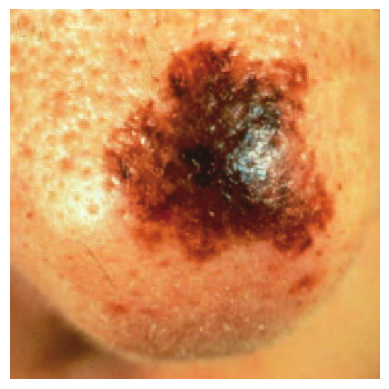

In [34]:
train_generator = create_generator(train_data, train_dir)
val_generator = create_generator(val_data, train_dir)
images, labels = next(train_generator)

image_index = 0
img = images[image_index]

plt.imshow(img)
plt.axis('off')
plt.show()

## 4. Build the model


In [39]:
model = Sequential([
    layers.Conv2D(32, (3, 3), activation=None, input_shape=(img_dim, img_dim, 3)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation=None),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation=None),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(num_classes, activation='softmax') 
])

model.compile(
    optimizer=Adam(learning_rate=1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy', F1Score(average='weighted')]
)

## 5. Train the Model


In [40]:
class PlotLearning(Callback):

       def on_train_begin(self, logs={}):
           self.i = 0
           self.x = []
           self.losses = []
           self.val_losses = []
           self.acc = []
           self.val_acc = []
           self.f1_score = []
           self.val_f1_score = []
           self.fig = plt.figure()

           self.logs = []

       def on_epoch_end(self, epoch, logs={}):

           self.logs.append(logs)
           self.x.append(self.i)
           self.losses.append(logs.get('loss'))
           self.val_losses.append(logs.get('val_loss'))
           self.acc.append(logs.get('accuracy'))
           self.val_acc.append(logs.get('val_accuracy'))
           self.f1_score.append(logs.get('f1_score'))
           self.val_f1_score.append(logs.get('val_f1_score'))
           self.i += 1
           f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(18,4))

           clear_output(wait=True)

           ax1.set_yscale('log')
           ax1.plot(self.x, self.losses, label="loss")
           ax1.plot(self.x, self.val_losses, label="val_loss")
           ax1.legend()

           ax2.plot(self.x, self.acc, label="accuracy")
           ax2.plot(self.x, self.val_acc, label="validation accuracy")
           ax2.legend()

           ax3.plot(self.x, self.f1_score, label="f1_score")
           ax3.plot(self.x, self.val_f1_score, label="validation f1_score")
           ax3.legend()

           plt.show();

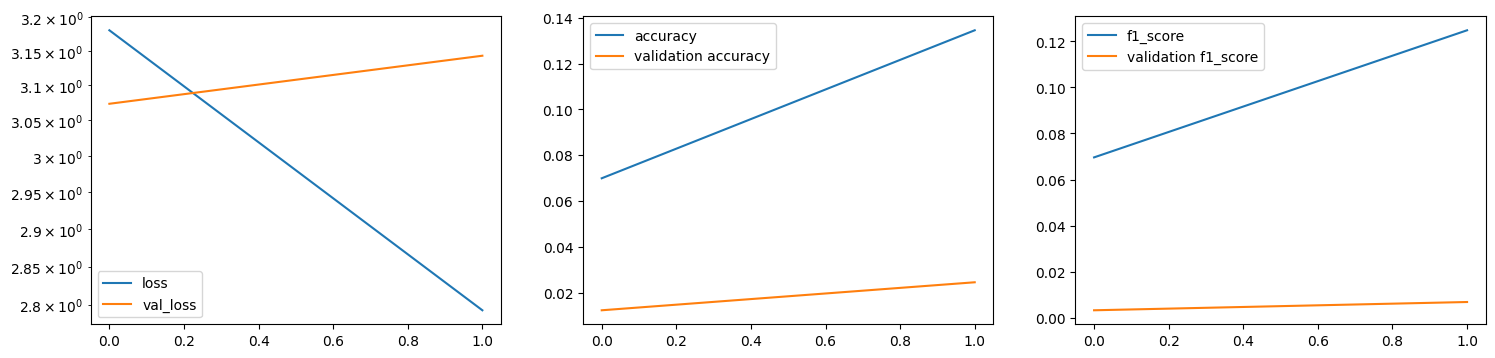

72/72 ━━━━━━━━━━━━━━━━━━━━ 914s 13s/step - accuracy: 0.1218 - f1_score: 0.1083 - loss: 2.8354 - val_accuracy: 0.0245 - val_f1_score: 0.0068 - val_loss: 3.1431
Epoch 3/20
50/72 ━━━━━━━━━━━━━━━━━━━━ 4:33 12s/step - accuracy: 0.1938 - f1_score: 0.1866 - loss: 2.5329

In [ ]:
early_stopping = EarlyStopping(monitor='val_f1_score', patience=10, restore_best_weights=True, mode='max')
all_labels = train_df['label']

class_weights = compute_class_weight('balanced', classes=np.unique(all_labels), y=all_labels)
class_weight_dict = {i: class_weights[i] for i in range(num_classes)}

plot = PlotLearning() # create an instance of the PlotLearning class

history = model.fit(
  train_generator,
  epochs=20,  # Adjust the number of epochs as needed 
  class_weight=class_weight_dict, 
  validation_data=val_generator,
  # callbacks=[plot] 
  callbacks=[early_stopping, plot] 
) 

In [ ]:
# Plot training & validation F1 score values
plt.figure(figsize=(12, 4))  # Adjust figure size if needed

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 3, 2)
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 3, 3)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

## 6. Make Predictions on Test Data

In [ ]:
def preprocess_test_data(test_df, directory):
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=directory,
        x_col='md5hash',
        y_col=None,
        target_size=(img_dim, img_dim),
        batch_size=32,
        class_mode=None,
        shuffle=False,
        validate_filenames=False  # Disable strict filename validation
    )
    return test_generator

In [ ]:
# Load test data
test_dir = '/kaggle/input/bttai-ajl-2025/test/test/'
test_generator = preprocess_test_data(test_df, test_dir)

## 7. Generate Predictions

In [ ]:
# Generate predictions based on the trained model
# Then, save the predictions into a CSV file for submission

predictions = model.predict(test_generator)

In [ ]:
predicted_labels = np.argmax(predictions, axis=1)
top_labels = label_encoder.inverse_transform(predicted_labels)
print("Predictions:", top_labels, '\n')
print("Unique:", np.unique(top_labels), '\n') # ensure the model isn't predicting the same thing every time
print(f"{len(np.unique(top_labels))}/{num_classes} classes were predicted")

In [ ]:
# remove .jpg extension
test_df['hash'] = test_df['md5hash'].apply(lambda x: os.path.splitext(x)[0])
test_df['hash'].head(3)

In [ ]:
final_df = pd.DataFrame({'md5hash': test_df['hash'], 'label': top_labels})
final_df.head()

In [ ]:
final_df.to_csv('submission_file.csv', index=False)

In [ ]:
# Print location of the csv file

print(os.getcwd())

print("done")